In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score



file_path = '/content/drive/MyDrive/Projeto IA/predictive_maintenance.csv'
dados = pd.read_csv(file_path)

PRE PROCESSAMENTO DOS DADOS

In [ ]:
# DESBALANCEAMENTO DO TARGET


distribuicao = dados['Target'].value_counts()
pct = dados['Target'].value_counts(normalize=True) * 100  # Multiplica por 100 para obter porcentagens

print(pct)

Target
0    96.61
1     3.39
Name: proportion, dtype: float64


In [ ]:
# PRINTANDO OS VALORES ÚNICOS DE CADA COLUNA DO DATAFRAME

for coluna in dados.columns:
    valores_unicos = dados[coluna].unique()
    print(f"'{coluna}': {valores_unicos}")

'UDI': [    1     2     3 ...  9998  9999 10000]
'Product ID': ['M14860' 'L47181' 'L47182' ... 'M24857' 'H39412' 'M24859']
'Type': ['M' 'L' 'H']
'Air temperature [K]': [298.1 298.2 298.3 298.5 298.4 298.6 298.7 298.8 298.9 299.  299.1 298.
 297.9 297.8 297.7 297.6 297.5 297.4 297.3 297.2 297.1 297.  296.9 296.8
 296.7 296.6 296.5 296.3 296.4 296.2 296.1 296.  295.9 295.8 295.7 295.6
 295.5 295.4 295.3 299.2 299.3 299.5 299.4 299.6 299.7 299.8 299.9 300.
 300.1 300.2 300.3 300.4 300.5 300.6 300.7 300.8 300.9 301.  301.1 301.2
 301.3 301.4 301.5 301.6 301.7 301.8 301.9 302.  302.1 302.2 302.3 302.4
 302.5 302.6 302.7 302.8 302.9 303.  303.1 303.2 303.3 303.4 303.5 303.6
 303.7 303.8 303.9 304.  304.1 304.2 304.3 304.4 304.5]
'Process temperature [K]': [308.6 308.7 308.5 309.  308.9 309.1 309.2 309.3 309.4 309.5 308.8 308.4
 308.3 308.2 308.1 308.  307.9 309.6 309.7 309.8 309.9 310.  310.1 310.2
 307.8 307.7 307.6 307.5 307.4 307.3 307.2 307.1 307.  306.9 306.8 306.7
 306.6 306.5 306.4 30

In [ ]:

# REMOÇÃO DOS ATRIBURTTOS DENECESSÁRIOS

dados.drop(columns=['UDI','Product ID','Failure Type'], inplace=True)



In [ ]:
# DISCRETIZAÇÃO SIMBOLICO NUMERICO DA COLUNA TYPE (MEDIUM, LOW and HIGH QUALITY)


dados = pd.get_dummies(dados, columns=['Type'], prefix='Type')
dados['Type_H'] = dados['Type_H'].astype(int)
dados['Type_M'] = dados['Type_M'].astype(int)
dados['Type_L'] = dados['Type_L'].astype(int)

# Organizando o dataframe para colocar o atributo target no final

cols = list(dados.columns)
cols.remove('Target')
cols.append('Target')
dados = dados[cols]

In [ ]:
# DADOS DESBALANCEADOS
#Temos 97% de não falhas e 3% de falhas no dataset



dados

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Type_H,Type_L,Type_M,Target
0,298.1,308.6,1551,42.8,0,0,0,1,0
1,298.2,308.7,1408,46.3,3,0,1,0,0
2,298.1,308.5,1498,49.4,5,0,1,0,0
3,298.2,308.6,1433,39.5,7,0,1,0,0
4,298.2,308.7,1408,40.0,9,0,1,0,0
...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,0,1,0
9996,298.9,308.4,1632,31.8,17,1,0,0,0
9997,299.0,308.6,1645,33.4,22,0,0,1,0
9998,299.0,308.7,1408,48.5,25,1,0,0,0


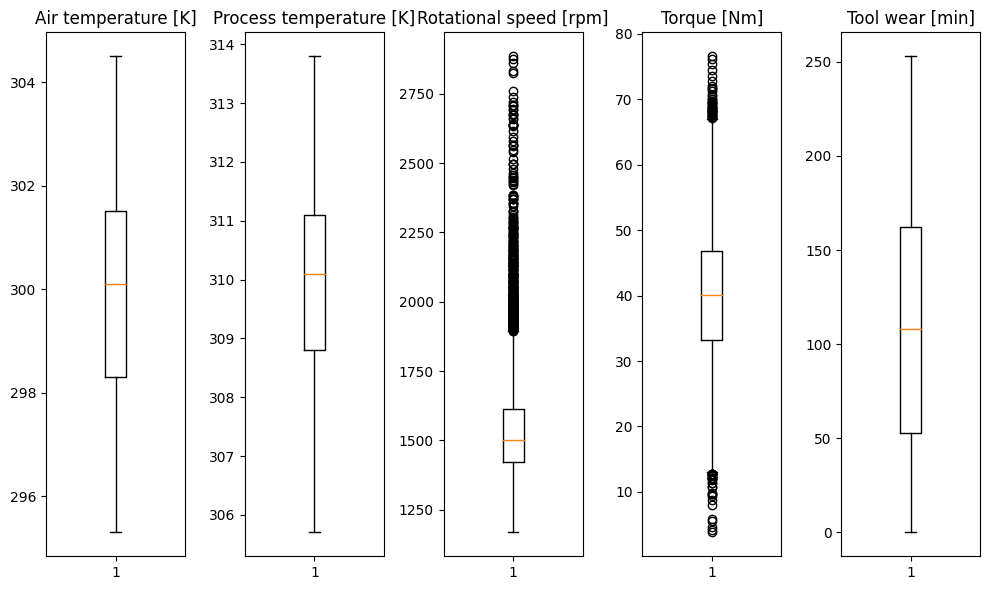


Valores ausentes por feature:

Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Type_H                     0
Type_L                     0
Type_M                     0
Target                     0
dtype: int64


Não tem linhas duplicadas.
Não tem colunas com valores completamente duplicados.


In [ ]:
# LIMPEZA DOS DADOS

features = dados.iloc[:,0:5]  # Pegando apenas as colunas numericas

# Detecção de Outliers -> No boxplot, observamos muitos outliers para o torque e a velocidade de rotação

plt.figure(figsize=(10, 6))

for i, column in enumerate(features.columns):
    plt.subplot(1, len(features.columns), i+1)
    plt.boxplot(features[column])
    plt.title(column)

plt.tight_layout()
plt.show()

# Detecção de Dados Incompletos

missing_values = dados.isnull().sum()

print(f"\nValores ausentes por feature:\n")
print(missing_values)
print(f"\n")

# Detecção de dados redundantes

duplicated_rows = dados[dados.duplicated()]

if  duplicated_rows.empty:
    print("Não tem linhas duplicadas.")
else:
    print("Linhas duplicadas:")
    print(duplicated_rows)

duplicated_columns = dados.columns[dados.T.duplicated()]

if len(duplicated_columns) > 0:
    print("Colunas com valores completamente duplicados:")
    print(duplicated_columns)
else:
    print("Não tem colunas com valores completamente duplicados.")



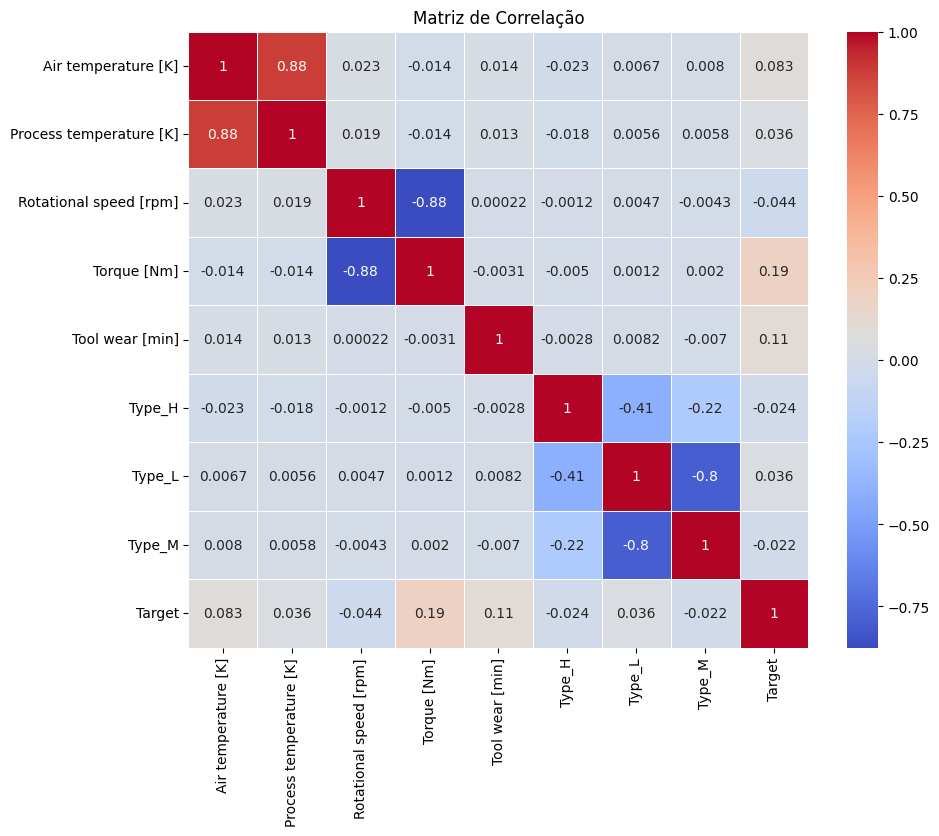

In [ ]:
# MATRIZ DE CORRELAÇÃO


correlation_matrix = dados.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()



In [ ]:
# Separando os dados em apenas dados de uma classe apara aplicar os algoritmos de detcção de anomalia porcausa do desbalancemaento entre as classes de falha (1) e não falha (0)

def divisão_dataset(dados_filtrados):

# Divisão das colunas (target e entradas) - No caso desse dataset a última coluna é o nosso target

  x_input = dados_filtrados.iloc[:,:-1]
  x_target = dados_filtrados.iloc[:,-1]

  tr = 0.6 # Treinamento - 60%
  vl = 0.2 # Validação - 20%
         # Teste - 20%

# Divisão das linhas do dataset

  train_i = int(tr*len(x_input))
  valid_i = int(vl*(len(x_input)))

  train_input = x_input.iloc[0:train_i,:]
  train_target = x_target.iloc[0:train_i]

  valid_input = x_input.iloc[train_i:train_i+valid_i,:]
  valid_target = x_target.iloc[train_i:train_i+valid_i]

  test_input = x_input.iloc[train_i+valid_i:,:]
  test_target = x_target.iloc[train_i+valid_i:]


# Normalização dos dados

  (l,cols)=np.shape(train_input)
  minmaxs=[]
  for i in range(cols): # Percorre todas as colunas do dataset
    min = np.min(train_input.iloc[:,i]) # Seleciona todas as linhas da coluna i e calcula o minimo
    max = np.max(train_input.iloc[:,i]) # Seleciona todas as linhas da coluna i e calcula o minimo
    minmaxs.append([min,max]) # Cria o vetor com todas os minimos e mximo por linha

# (X - min)/(max - min) - Reescala todos os dados para os tres datasets com base nos respectivos minmos e maximos de cada coluna-linha

  for i in range(cols):
    train_input.iloc[:,i] = (train_input.iloc[:,i]-minmaxs[i][0])/(minmaxs[i][1]-minmaxs[i][0]) # Seleciona todos os valores da primeira coluna e faz o calculo utilizado a lista de lista  minmax[coluna][0] = minimo daqulesa coluna ; minmax[coluna][1] = maximo daquela coluna
    valid_input.iloc[:,i] = (valid_input.iloc[:,i]-minmaxs[i][0])/(minmaxs[i][1]-minmaxs[i][0])
    test_input.iloc[:,i] = (test_input.iloc[:,i]-minmaxs[i][0])/(minmaxs[i][1]-minmaxs[i][0])

  return train_input, valid_input, test_input, test_target, valid_target

In [ ]:
# ONE CLASS SVM

# Divsão dos dados

dados_nao_falha = dados[dados['Target'] == 0] # Apenas onde nãoa conteceu fahas
train_nao_falha, valid_nao_falha, teste_não_falha, teste_naofalha_target, valid_naofalha_target = divisão_dataset(dados_nao_falha)
X_train , X_valid, X_test, Y_test, Y_valid = divisão_dataset(dados) # Ddos onde acontece co falahs e não falhas (todo o dataset)


best_ocvm = 0
prec_top = 0.0
acc_top=0.0


nus = [0.1,0.01,0.001,0.0001,0.00001,0.000001] # Range de interceptação para outliers
kernels =['rbf', 'linear','poly'] # Função que muda como ampliamos as dimensões para interceptar a divisão do plano -> rbf eh usada comom padrão apos diversos testes ela que apresenta a melhor acuracia
gammas=[1,1.5,2,20,100] # Controla a influência de cada amostra de treinamento no modelo

# Treinamento e Validação

for k in kernels:
  for n in nus:
    for g in gammas:

        one_class_svm = OneClassSVM(nu=n,kernel=k, gamma=g)

        one_class_svm.fit(train_nao_falha)
        preds = one_class_svm.predict(X_valid) # 1 normal (nao_falha) e -1 anomalia (falha)
        acc = accuracy_score(preds,Y_valid.map({0: 1,1: -1})) # Mapeamento para fazer a conversão do target(1,0) para o preds (-1,1)

        if acc > acc_top:  # Escolha do melhor modelo com base na acurácia
          acc_top=acc
          best_ocvm = one_class_svm

pred_test = best_ocvm.predict(X_test)
pred_test = pd.Series(pred_test) # 1 para normal (sem falha), -1 para anomalia (falha)

# Cálculo das métricas

acc_test = accuracy_score(pred_test,Y_test.map({0: 1,1: -1}))  # Acurácia
prec_test = precision_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary') # Precisão
recall_test =  recall_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary') # Recall
f1 =  f1_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary') # F1 Score

conf_matrix = confusion_matrix(Y_test.map({0: 1,1: -1}), pred_test) # Matriz de confusão
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Acurácia: {acc_test}')
print(f'Precision: {prec_test}')
print(f'Recall: {recall_test}')
print(f'F1 Score: {f1} \n')

print(f'Verdadeiro Negativo: {tn}')
print(f'Verdadeiro Positivo: {tp}')
print(f'Falso Negativo: {fn}')
print(f'Falso Positivo: {fp}')


Acurácia: 0.983
Precision: 0.988342625443487
Recall: 0.9943906170321265
F1 Score: 0.9913573970513474 

Verdadeiro Negativo: 16
Verdadeiro Positivo: 1950
Falso Negativo: 11
Falso Positivo: 23


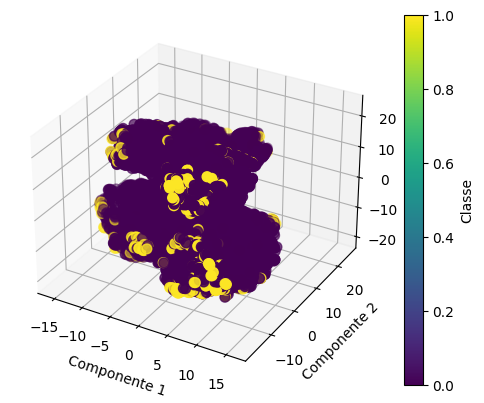

Acurácia: 0.983
Precision: 0.9839276745354093
Recall: 0.9989801121876594
F1 Score: 0.9913967611336032 

Verdadeiro Negativo: 7
Verdadeiro Positivo: 1959
Falso Negativo: 2
Falso Positivo: 32


In [ ]:
# ONE CLASS SVM + t-SNE

# Divisão dos dados

X = dados.iloc[:,:-1]
y = dados.iloc[:,-1]

# t-SNE

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Reescalando os dados para o modelo t-SNE
tsne = TSNE(n_components=3, random_state=42)  # Reduzir para 3 dimensões
X_tsne = tsne.fit_transform(X_scaled) # Aplicando o modelo

# Plot dos dados na nova dimensão

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y, cmap='viridis', s=50)
plt.colorbar(scatter, ax=ax, label='Classe')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.show()

nova_projeção = pd.DataFrame(X_tsne, columns=[f'feature_{i}' for i in range(X_tsne.shape[1])]) #nova_projeção.reset_index(drop=True)
y_tsne = y.reset_index(drop=True)

combined_df = pd.concat([nova_projeção, y_tsne], axis=1)

# Divisão dos dados

dados_nao_falha = combined_df[combined_df['Target'] == 0] # Não contém falhas
train_nao_falha, valid_nao_falha, teste_não_falha, teste_naofalha_target, valid_naofalha_target = divisão_dataset(dados_nao_falha) # Contém falhas e não falhas

X_train , X_valid, X_test, Y_test, Y_valid = divisão_dataset(combined_df)


best_ocvm = 0
prec_top = 0.0
acc_top=0.0


nus = [0.1,0.01,0.001,0.0001,0.00001,0.000001] # Range de interceptação para outliers
kernels =['rbf', 'linear','poly'] # Função que muda como ampliamos as dimensões para interceptar a divisão do plano
gammas=[1,1.5,2,20,200]

# Treinamento e Validação

for k in kernels:
  for n in nus:
    for g in gammas:

        one_class_svm = OneClassSVM(nu=n,kernel=k, gamma=g)

        one_class_svm.fit(train_nao_falha)
        preds = one_class_svm.predict(X_valid) # 1 normal (nao_falha) e -1 anomalia (falha)
        acc = accuracy_score(preds,Y_valid.map({0: 1,1: -1}))

        if acc > acc_top:
          acc_top=acc
          best_ocvm = one_class_svm

# Teste

pred_test = best_ocvm.predict(X_test)
pred_test = pd.Series(pred_test) # 1 para normal (sem falha), -1 para anomalia (falha)

# Cálculo das Métricas

acc_test = accuracy_score(pred_test,Y_test.map({0: 1,1: -1}))  # Acurácia
prec_test = precision_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary')
recall_test =  recall_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary')
f1 =  f1_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary')

conf_matrix = confusion_matrix(Y_test.map({0: 1,1: -1}), pred_test)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Acurácia: {acc_test}')
print(f'Precision: {prec_test}')
print(f'Recall: {recall_test}')
print(f'F1 Score: {f1} \n')

print(f'Verdadeiro Negativo: {tn}')
print(f'Verdadeiro Positivo: {tp}')
print(f'Falso Negativo: {fn}')
print(f'Falso Positivo: {fp}')


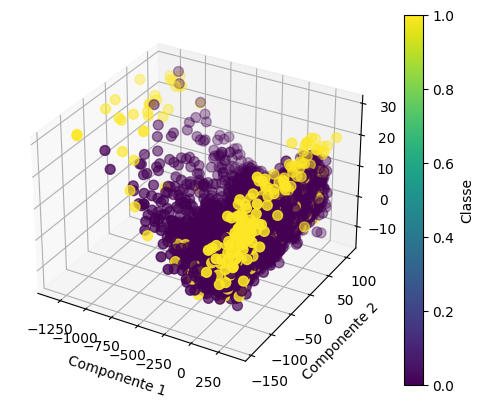

Acurácia: 0.9865
Precision: 0.9869083585095669
Recall: 0.9994900560938297
F1 Score: 0.9931593615404104 

Verdadeiro Negativo: 13
Verdadeiro Positivo: 1960
Falso Negativo: 1
Falso Positivo: 26


In [ ]:
# ONECLASS SVM + PCA

# Divsão dos dados

x_input_pca = dados.iloc[:, :-1]
x_target_pca = dados.iloc[:, -1]

# Aplicação da analise de componentes

media_pca = x_input_pca.mean(axis=0) # Média
central = x_input_pca - media_pca # Centralização com base na média
covar = central.cov() # Covariação
eigenvalues, eigenvectors = np.linalg.eig(covar) # Autovetores e autovlores


K = 3 # Reduzindo a dimensionalidade de n para 3 dimensões com base nos autovalores e autovetores
autovetores_sel = eigenvectors[:, :K]
autovalores_sel = eigenvalues[:K]

# Nova projeção PCA
nova_projeção = central.dot(autovetores_sel)

nova_projeção = nova_projeção.reset_index(drop=True)
x_target_pca = x_target_pca.reset_index(drop=True)

combined_df = pd.concat([nova_projeção, x_target_pca], axis=1) # Juntando target + novos dados transformados pelo PCA

# Plot para vizualização dos dados

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(combined_df.iloc[:, 0], combined_df.iloc[:, 1], combined_df.iloc[:, 2], c=combined_df.iloc[:, -1], cmap='viridis', s=50)
plt.colorbar(scatter, ax=ax, label='Classe')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
plt.show()

dados_nao_falha = combined_df[combined_df['Target'] == 0]

train_nao_falha, valid_nao_falha, teste_não_falha, teste_naofalha_target, valid_naofalha_target = divisão_dataset(dados_nao_falha) # Dados com apenas onde não houve falha
X_train , X_valid, X_test, Y_test, Y_valid = divisão_dataset(combined_df) # Ddaos com exemplos de onde houve falhas e não falhas


best_ocvm = 0
prec_top = 0.0
acc_top=0.0


nus = [0.1,0.01,0.001,0.0001,0.00001,0.000001] # Range de interceptação para outliers
kernels =['rbf', 'linear','poly'] # Função que muda como ampliamos as dimensões para interceptar a divisão do plano
gammas=[1,1.5,2,20,200]

# Busca do melhor modelo com os melhores parametros (Validação e Treinamento)

for k in kernels:
  for n in nus:
    for g in gammas:

        one_class_svm = OneClassSVM(nu=n,kernel=k, gamma=g)

        one_class_svm.fit(train_nao_falha)
        preds = one_class_svm.predict(X_valid) # 1 normal (nao_falha) e -1 anomalia (falha)
        acc = accuracy_score(preds,Y_valid.map({0: 1,1: -1}))

        if acc > acc_top: # melhor acuracia e melhor modelo
          acc_top=acc
          best_ocvm = one_class_svm


# Teste

pred_test = best_ocvm.predict(X_test)
pred_test = pd.Series(pred_test) # 1 para normal (sem falha), -1 para anomalia (falha)

# Cálculo das Métricas

acc_test = accuracy_score(pred_test,Y_test.map({0: 1,1: -1}))  # Acurácia
prec_test = precision_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary')
recall_test =  recall_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary')
f1 =  f1_score(Y_test.map({0: 1,1: -1}), pred_test,average='binary')

conf_matrix = confusion_matrix(Y_test.map({0: 1,1: -1}), pred_test)
tn, fp, fn, tp = conf_matrix.ravel()

print(f'Acurácia: {acc_test}')
print(f'Precision: {prec_test}')
print(f'Recall: {recall_test}')
print(f'F1 Score: {f1} \n')

print(f'Verdadeiro Negativo: {tn}')
print(f'Verdadeiro Positivo: {tp}')
print(f'Falso Negativo: {fn}')
print(f'Falso Positivo: {fp}')
